In [1]:
# Installing all utility packages
!pip install git+https://github.com/nghorbani/configer
!pip install git+https://github.com/nghorbani/human_body_prior
!pip install git+https://github.com/nghorbani/amass

  Cloning https://github.com/nghorbani/configer to /tmp/pip-req-build-zzt1ohuq
  Running command git clone --filter=blob:none --quiet https://github.com/nghorbani/configer /tmp/pip-req-build-zzt1ohuq
  Resolved https://github.com/nghorbani/configer to commit 8cd1e3e556d9697298907800a743e120be57ac36
  Preparing metadata (setup.py) ... done
  Created wheel for configer: filename=configer-1.4.1-py3-none-any.whl size=7838 sha256=df40d639b23c781c99b40da0252419aa01b1fa43c21fce006ed0adeeae23bf70
  Stored in directory: /tmp/pip-ephem-wheel-cache-ei1g0wvr/wheels/05/22/ea/db8ac88e6ea839287675cbe7eb5923e2307ad8ee28ac29d58e
Successfully built configer
  Cloning https://github.com/nghorbani/human_body_prior to /tmp/pip-req-build-6gv5ybmr
  Running command git clone --filter=blob:none --quiet https://github.com/nghorbani/human_body_prior /tmp/pip-req-build-6gv5ybmr
  Resolved https://github.com/nghorbani/human_body_prior to commit 4c246d8a83ce16d3cff9c79dcf04d81fa440a6bc
  Preparing metadata (setup.

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from human_body_prior.tools.omni_tools import copy2cpu as c2c

# Selecting device CPU/GPU for running the body model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device :{device}")

Device :cpu


In [2]:
from human_body_prior.body_model.body_model import BodyModel

SMPL_path = '/home/kulendu/SMPL-Manipulation/smplh/male/model.npz'
DMPL_path = '/home/kulendu/SMPL-Manipulation/dmpls/male/model.npz'

# defining the beta (shape coefficient)
SMPL_betas = 10
DMPL_betas = 8

body_model = BodyModel(bm_fname = SMPL_path, num_betas = SMPL_betas, num_dmpls = DMPL_betas, dmpl_fname = DMPL_path).to(device)
faces = c2c(body_model.f)

In [3]:
AMASS_sample_data = "/home/kulendu/SMPL-Manipulation/ACCAD/Male2MartialArtsExtended_c3d/Extended_1_stageii.npz"
body_data = np.load(AMASS_sample_data)


print('Data keys available:%s'%list(body_data.keys()))
print('Vector poses has %d elements for each of %d frames.'%(body_data['poses'].shape[1], body_data['poses'].shape[0]))
# print('Vector dmpls has %d elements for each of %d frames.'%(body_data['dmpls'].shape[1], body_data['dmpls'].shape[0]))
print('Vector trams has %d elements for each of %d frames.'%(body_data['trans'].shape[1], body_data['trans'].shape[0]))
print('Vector betas has %d elements constant for the whole sequence.'%body_data['betas'].shape[0])
print('The subject of the mocap sequence is %s.'%body_data['gender'])

Data keys available:['gender', 'surface_model_type', 'mocap_frame_rate', 'mocap_time_length', 'markers_latent', 'latent_labels', 'markers_latent_vids', 'trans', 'poses', 'betas', 'num_betas', 'root_orient', 'pose_body', 'pose_hand', 'pose_jaw', 'pose_eye', 'markers', 'labels', 'markers_obs', 'labels_obs', 'markers_sim', 'marker_meta', 'num_markers']
Vector poses has 165 elements for each of 2408 frames.
Vector trams has 3 elements for each of 2408 frames.
Vector betas has 16 elements constant for the whole sequence.
The subject of the mocap sequence is male.


In [4]:
f_id = 0 # frame ID of the sequence

root_orient = torch.Tensor(body_data['poses'][f_id:f_id+1, :3]).to(device) # controls the global root orientation
pose_body = torch.Tensor(body_data['poses'][f_id:f_id+1, 3:66]).to(device) # controls the body
pose_hand = torch.Tensor(body_data['poses'][f_id:f_id+1, 66:]).to(device) # controls the finger articulation
betas = torch.Tensor(body_data['betas'][:10][np.newaxis]).to(device) # controls the body shape
trans = torch.Tensor(body_data['trans']).to(device) # global translation

print(f"Shape of the Root orientation - {root_orient.shape}")
print(f"Shape Body pose - {pose_body.shape}")
print(f"Shape of Hands - {pose_hand.shape}")

Shape of the Root orientation - torch.Size([1, 3])
Shape Body pose - torch.Size([1, 63])
Shape of Hands - torch.Size([1, 99])


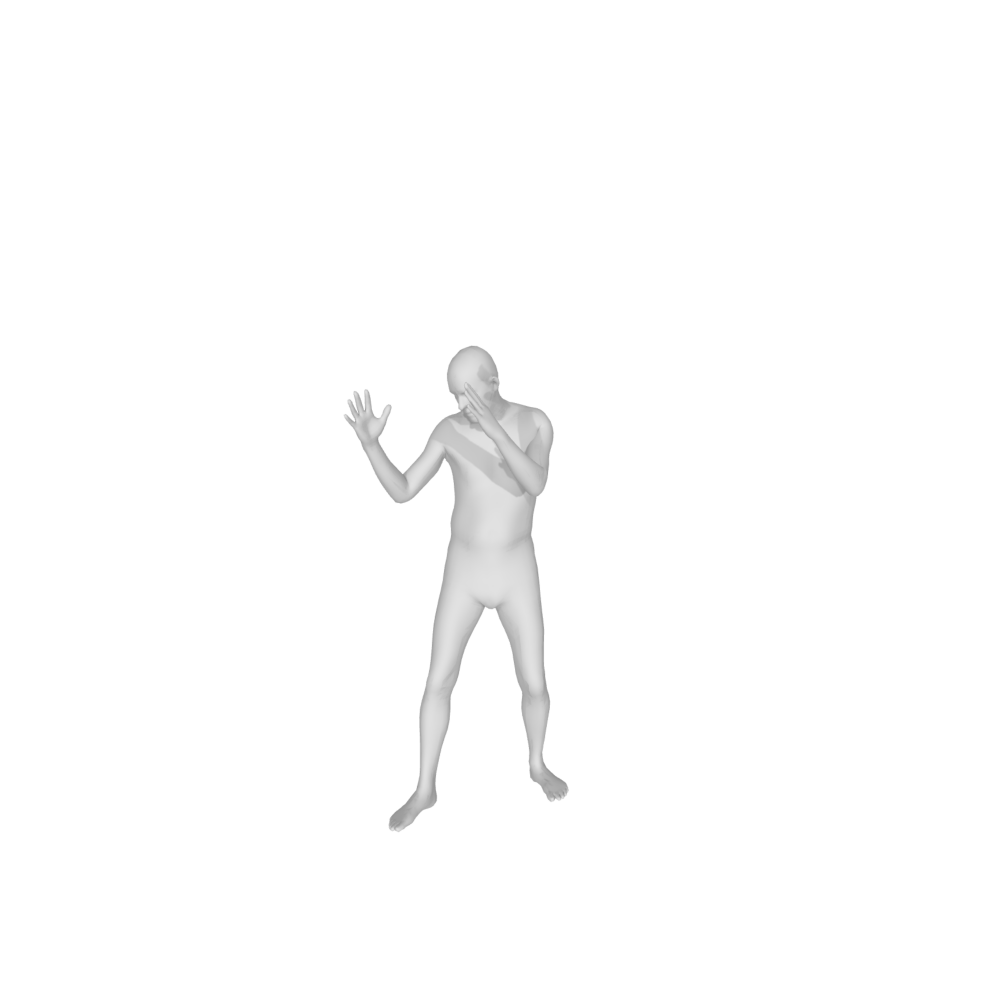

In [6]:
body = body_model(pose_body=pose_body, betas=betas)
body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=False)
show_image(body_image)

In [5]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

## Changing the Global Root Orientation
Changing the global rotation/translation. This can change the SMPL's position and orientation with the **trans** and **root_orient** parameters

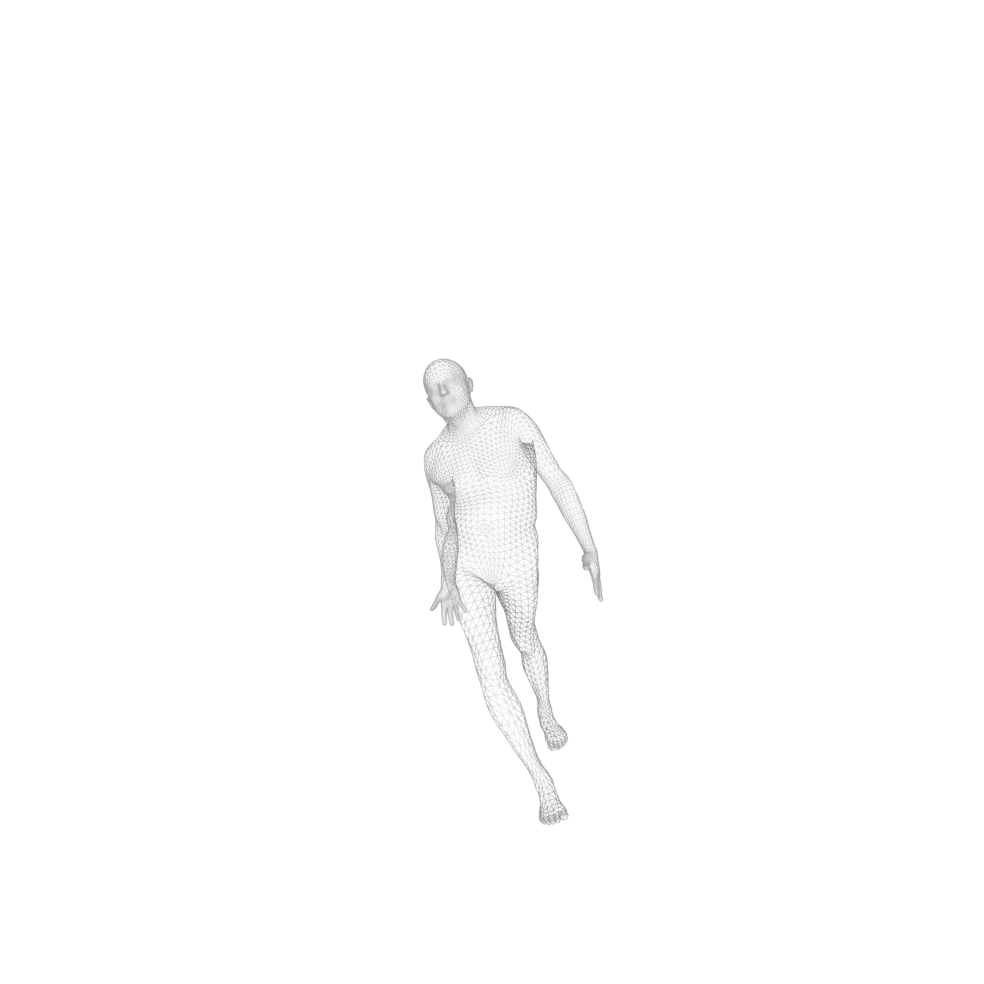

In [38]:
body_trans_rot = body_model(pose_body=pose_body, betas=betas, root_orient=root_orient)

body_mesh = trimesh.Trimesh(vertices=c2c(body_trans_root.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=True)
show_image(body_image)


In [11]:
import torch
import numpy as np

from human_body_prior.body_model.body_model import BodyModel
from human_body_prior.tools.omni_tools import copy2cpu as c2c

# bm_path = './human_body_prior-master/human_body_prior/body_model/smplh/male/model.npz' # obtain from http://mano.is.tue.mpg.de/downloads
bm_path = AMASS_sample_data

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bm = BodyModel(bm_fname=bm_path, batch_size=1, num_betas=10).to(comp_device)

npz_data_path = '/home/kulendu/SMPL-Manipulation/ACCAD/Male2MartialArtsExtended_c3d/Extended_1_stageii.npz'
bdata = np.load(npz_data_path)
print(list(bdata.keys()))

root_orient = torch.Tensor(bdata['poses'][:, :4]).to(comp_device)
pose_body = torch.Tensor(bdata['poses'][:, 4:66]).to(comp_device)
pose_hand = torch.Tensor(bdata['poses'][:, 66:]).to(comp_device)
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device)

faces = c2c(bm.f)

from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.tools.visualization_tools import imagearray2file
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
from tqdm import tqdm

imw, imh=600, 400
step = 10
T = bdata['poses'].shape[0]//step

mv = MeshViewer(width=imw, height=imh, use_offscreen=True)
images = np.zeros([2, 3, T, imh, imw, 3], dtype=np.float32)

count = 0
for fId in tqdm(range(1, bdata['poses'].shape[0], step)):
    if count > T: break
    body = bm(pose_body=pose_body[fId:fId+1], pose_hand=pose_hand[fId:fId+1], betas=betas, root_orient=root_orient[fId:fId+1])

    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    joints_mesh = points_to_spheres(c2c(body.Jtr[0]), vc=colors['red'])
    mrks = bdata['marker_data'][fId] - bdata['trans'][fId]
    mrks_mesh = points_to_spheres(mrks, vc=colors['blue'])

    all_meshes = [body_mesh] + joints_mesh + mrks_mesh
    apply_mesh_tranfsormations_(all_meshes, trimesh.transformations.rotation_matrix(np.radians(-90), (1, 0, 0)))
    apply_mesh_tranfsormations_(all_meshes, trimesh.transformations.rotation_matrix(np.radians(-90), (0, 1, 0)))
    mv.set_static_meshes(mrks_mesh)
    images[0, 0, count] = mv.render()
    mv.set_static_meshes([body_mesh])
    images[0, 1, count] = mv.render()
    mv.set_static_meshes([body_mesh]+joints_mesh)
    images[0, 2, count] = mv.render(render_wireframe=True)

    apply_mesh_tranfsormations_(all_meshes, trimesh.transformations.rotation_matrix(np.radians(90), (0, 1, 0)))
    mv.set_static_meshes(mrks_mesh)
    images[1, 0, count] = mv.render()
    mv.set_static_meshes([body_mesh])
    images[1, 1, count] = mv.render()
    mv.set_static_meshes([body_mesh]+joints_mesh)
    images[1, 2, count] = mv.render(render_wireframe=True)
    count += 1


imagearray2file(images, './teaser.gif')

TypeError: __init__() got an unexpected keyword argument 'batch_size'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from smplx import SMPL
import trimesh

# Path to the AMASS dataset file
amass_file = '/home/kulendu/SMPL-Manipulation/ACCAD/Male2MartialArtsExtended_c3d/Extended_1_stageii.npz'

# Load the dataset
data = np.load(amass_file)

# Verify content of the .npz file
print(data.files)

# Extract one frame (let's take the first frame for simplicity)
frame_index = 100
poses = data['poses'][frame_index]
betas = data['betas'][:10]
trans = data['trans'][frame_index]

# Path to the SMPL model directory (make sure you have the SMPL model files in the specified directory)
smpl_model_path = '/home/kulendu/SMPL-Manipulation/SMPL_NEUTRAL.pkl'

# Load SMPL model
smpl = SMPL(model_path=smpl_model_path, gender='neutral', create_transl=False)

# Ensure we use the first 72 parameters if the dataset provides more
poses = poses[:72]

# Ensure betas have length 10
if len(betas) != 10:
    raise ValueError(f"Expected shape parameters (betas) of length 10, but got {len(betas)}")

# Convert pose and shape to tensors with float32 type
body_pose = torch.tensor(poses[3:], dtype=torch.float32).unsqueeze(0)  # Exclude the global orientation
global_orient = torch.tensor(poses[:3], dtype=torch.float32).unsqueeze(0)
betas = torch.tensor(betas, dtype=torch.float32).unsqueeze(0)
trans = torch.tensor(trans, dtype=torch.float32).unsqueeze(0)
faces = smpl.faces

# Generate body mesh from pose and shape
output = smpl(global_orient=global_orient, body_pose=body_pose, betas=betas)
vertices = output.vertices[0].detach().numpy()

print('No. of Frames:', len(data['poses']))

# Visualize the frame
mesh = trimesh.Trimesh(vertices, faces)
mesh.show()




['gender', 'surface_model_type', 'mocap_frame_rate', 'mocap_time_length', 'markers_latent', 'latent_labels', 'markers_latent_vids', 'trans', 'poses', 'betas', 'num_betas', 'root_orient', 'pose_body', 'pose_hand', 'pose_jaw', 'pose_eye', 'markers', 'labels', 'markers_obs', 'labels_obs', 'markers_sim', 'marker_meta', 'num_markers']
No. of Frames: 2408


In [61]:
import numpy as np
import torch
import trimesh
import imageio
from smplx import SMPL
import io
from PIL import Image




# Load the dataset
data = np.load(amass_file)

# Inspect the shapes
print(f"Poses shape: {data['poses'].shape}")
print(f"First few pose parameters: {data['poses'][0][:10]}")  # Print first few pose values for inspection
print(f"Betas shape: {data['betas'].shape}")
print(f"Trans shape: {data['trans'].shape}")

# Load SMPL model
smpl = SMPL(model_path=smpl_model_path, gender='neutral', create_transl=False)

# Ensure betas have length 10
betas = data['betas'][:10]  # Ensure betas have length 10
if len(betas) != 10:
    raise ValueError(f"Expected shape parameters (betas) of length 10, but got {len(betas)}")

# Iterate through all frames, generate meshes, and save as GIF
output_directory = 'scene_images'
os.makedirs(output_directory, exist_ok=True)
frames = []
for i in range(len(data['poses'])):
    # Extract pose and translation for current frame
    poses = data['poses'][i]
    trans = data['trans'][i]
    
    # Ensure we use the first 72 parameters if the dataset provides more
    poses = poses[:72]

    # Convert pose and shape to tensors with float32 type
    body_pose = torch.tensor(poses[3:], dtype=torch.float32).unsqueeze(0)  # Exclude the global orientation
    global_orient = torch.tensor(poses[:3], dtype=torch.float32).unsqueeze(0)
    betas = torch.tensor(betas, dtype=torch.float32).unsqueeze(0)
    trans = torch.tensor(trans, dtype=torch.float32).unsqueeze(0)

    # Generate body mesh from pose and shape
    output = smpl(global_orient=global_orient, body_pose=body_pose, betas=betas)
    vertices = output.vertices[0].detach().numpy()
    faces = smpl.faces

    # Create a Trimesh object
    mesh = trimesh.Trimesh(vertices, faces)

    # Create a scene with the mesh
    scene = trimesh.Scene(mesh)

    # Render the scene as an image
    image = scene.save_image(resolution=(800, 600))

    # Append the image to the frames list
    frames.append(image)

# Save frames as a GIF
imageio.mimsave('amass_frames.gif', frames, duration=0.1)  # Adjust duration as needed



Poses shape: (2408, 165)
First few pose parameters: [ 0.85249386 -1.49519233 -1.71182766  0.01658733  0.0695489   0.17109091
 -0.11937338 -0.17361319 -0.25918944  0.05432229]
Betas shape: (16,)
Trans shape: (2408, 3)


AttributeError: 'SceneViewer' object has no attribute 'ubo'

In [67]:
import numpy as np
import torch
import trimesh
import imageio
from smplx import SMPL
import io
from PIL import Image




# Load the dataset
data = np.load(amass_file)

# Inspect the shapes
print(f"Poses shape: {data['poses'].shape}")
print(f"First few pose parameters: {data['poses'][0][:10]}")  # Print first few pose values for inspection
print(f"Betas shape: {data['betas'].shape}")
print(f"Trans shape: {data['trans'].shape}")

# Load SMPL model
smpl = SMPL(model_path=smpl_model_path, gender='neutral', create_transl=False)

# Ensure betas have length 10
betas = data['betas'][:10]  # Ensure betas have length 10
if len(betas) != 10:
    raise ValueError(f"Expected shape parameters (betas) of length 10, but got {len(betas)}")

# Iterate through all frames, generate meshes, and save as GIF
output_directory = 'scene_images'
os.makedirs(output_directory, exist_ok=True)
frames = []
for i in range(len(data['poses'])):
    # Extract pose and translation for current frame
    poses = data['poses'][i]
    trans = data['trans'][i]
    
    # Ensure we use the first 72 parameters if the dataset provides more
    poses = poses[:72]

    # Convert pose and shape to tensors with float32 type
    body_pose = torch.tensor(poses[3:], dtype=torch.float32).unsqueeze(0)  # Exclude the global orientation
    global_orient = torch.tensor(poses[:3], dtype=torch.float32).unsqueeze(0)
    betas = torch.tensor(betas, dtype=torch.float32).unsqueeze(0)
    trans = torch.tensor(trans, dtype=torch.float32).unsqueeze(0)

    # Generate body mesh from pose and shape
    output = smpl(global_orient=global_orient, body_pose=body_pose, betas=betas)
    vertices = output.vertices[0].detach().numpy()
    faces = smpl.faces

    # Create a Trimesh object
    mesh = trimesh.Trimesh(vertices, faces)

    # Create a scene with the mesh
    scene = trimesh.Scene()
    scene.add_geometry(mesh)

    # Render the scene as an image
    scene.save_image('scene_image.png', resolution=(800, 600))



Poses shape: (2408, 165)
First few pose parameters: [ 0.85249386 -1.49519233 -1.71182766  0.01658733  0.0695489   0.17109091
 -0.11937338 -0.17361319 -0.25918944  0.05432229]
Betas shape: (16,)
Trans shape: (2408, 3)


TypeError: save_image() got multiple values for argument 'resolution'